In [218]:
import prophet
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error


print('Prophet %s' % prophet.__version__)

Prophet 1.1.4


# Yapılacaklar

- Öncelikle model eğitilicek ve modelin genel performansına bakacağız.
- Elimizdeki örnekler gelecek yıl için bir tahminde bulunacağız.
- Elimizdeki verini son bir yılını test için ayırıp bu kismi tahmin edip gercek degerler ile karşılaştıracağız.


In [219]:
data = pd.read_csv("monthly-car-sales.csv")
data.tail(4)

,Month,Sales
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180
107,1968-12,14577


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0, 0.5, 'Sales')

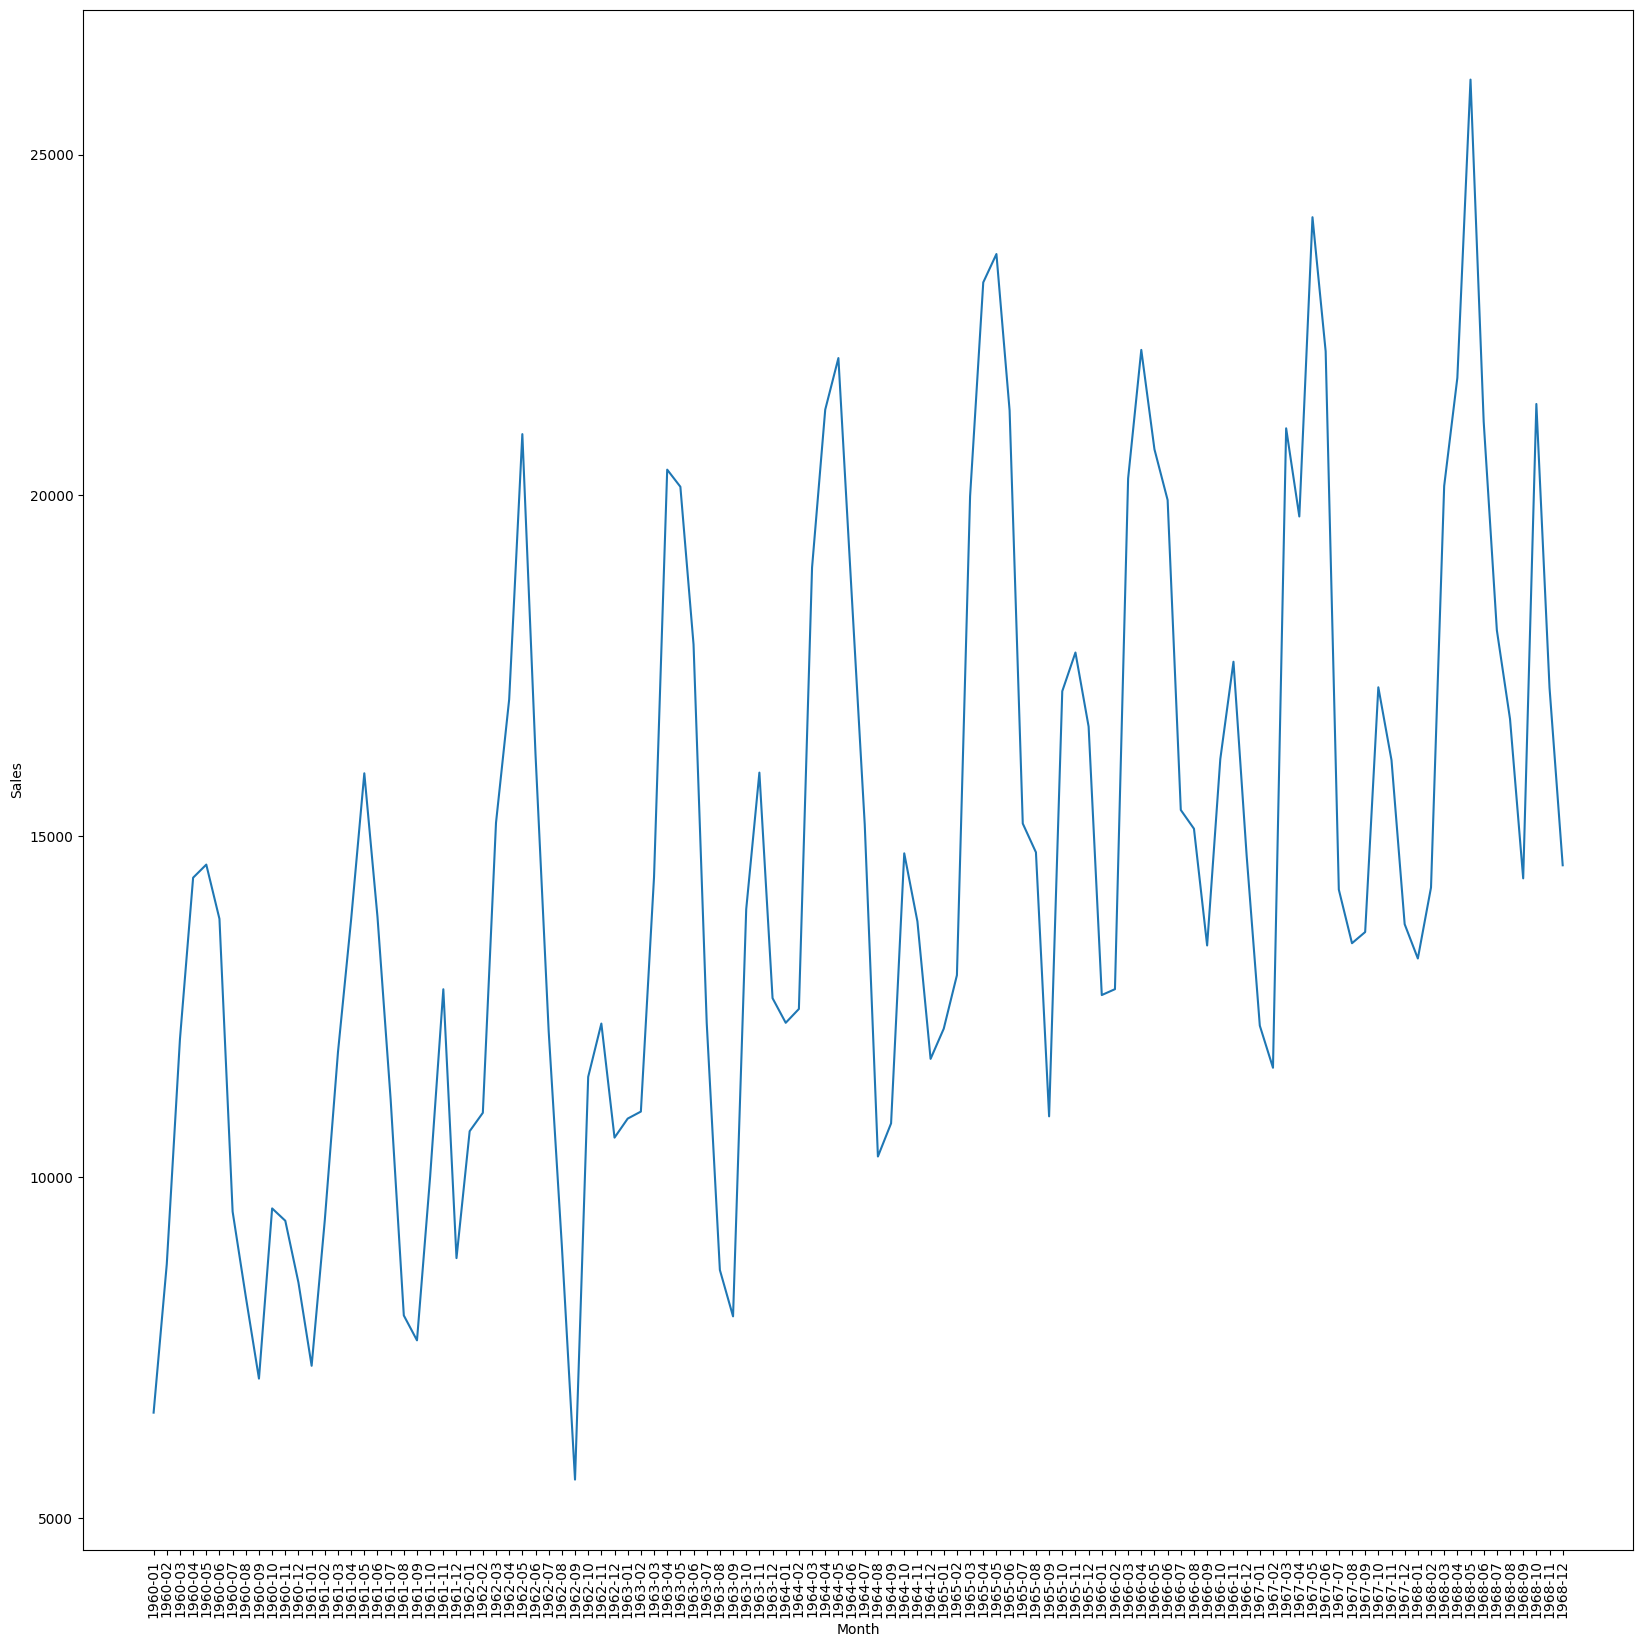

In [220]:
# Zaman serisinin incelenmesi

plt.figure(figsize=(20, 20))

sns.lineplot(data=data, x="Month", y="Sales")
plt.xlabel("Month")
plt.xticks(rotation=90)

plt.ylabel("Sales")

### Yorumlar

- Yükselen bir trend'imiz var.
- Bir de mevsimsellik görüyoruz.


In [221]:
# Veri setindeki tiplerin kontrol edilmesi

data.dtypes

Month    object
Sales     int64
dtype: object

In [222]:
# columns'ların prophet modeline uygun hale getirilmesi
# İlk sutun ds ve tarih içermeli. Hedef sutünda y adına sahip olmalıdır.

data.columns = ['ds', 'y']


# Month type object --> datetime
data['ds'] = pd.to_datetime(data['ds'])

In [223]:
data.dtypes

ds    datetime64[ns]
y              int64
dtype: object

### Model Oluşturma


In [224]:
from prophet import Prophet

model = Prophet()

model.fit(data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:finish chain 1


## Birinci Senaryo: Örnek içi Tahmin Yapmak

- Geçmiş veriler üzerinden bir tahmin yapmak faydalı olabilir.

- Yani, modeli eğitmek için girdi olarak kullanılan veriler üzerinde bir tahmin yapabiliriz. İdeal olarak, model verileri daha önce görmüştür ve mükemmel tahminde bulunur.

- Buna örnek içi(eğitim kümesinde) tahmin yapmak denir ve sonuçların gözden geçirilmesi modelin ne kadar iyi olduğuna dair bir fikir verebilir.

- "predict()" methodu tüm aralıklar için tahmin edilecek.


In [225]:
#Şimdi ilgili veri setindeki 1968'deki her ay için bir tahmin yapmaya çalışacağız.

def createDateTime(year,lowerRange,UpperRange):
    """
    for i in range(1,13):
        date= '1968-%02d' %i
        print(date)

        tarih oluşturma: outputs are 
    ['1970-01', '1970-02', '1970-03', '1970-04', '1970-05', '1970-06', '1970-07', '1970-08', '1970-09', '1970-10', '1970-11', '1970-12']
    """
    dateList=list()
    for i in range(lowerRange,UpperRange):
        date=f'{year}-%02d'%i
        dateList.append(date)
    return dateList



today=createDateTime(1968,1,13)

In [226]:
#Bu today list'ten DataFrame çevirme

today_df=pd.DataFrame(data=today,columns=["ds"])
today_df.head(3)

,ds
0,1968-01
1,1968-02
2,1968-03


In [227]:
print(today_df.dtypes)

ds    object
dtype: object


In [228]:
#Tipini dönüştürme object ---> datetime
today_df['ds']=pd.to_datetime(today_df['ds'])
print(today_df.dtypes)

ds    datetime64[ns]
dtype: object


- Tahmin işlemi


In [229]:
#Bu sayıya gelen sayıyı tahmin et!

forecasting=model.predict(today_df)

Dikkat edilmesi gereken sutünlar:

- tahmini tarih saat('ds')

- tahmini değer('yhat')

- tahmin edilen değerin alt ve üst sınırları('y_hat_lower, y_hat_upper')


In [230]:
#önemli sutunları gözden geçirme
forecasting[["ds","yhat","yhat_lower","yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,1968-01-01,14340.144249,12685.911879,15873.969438
1,1968-02-01,14908.656241,13402.838252,16532.036948
2,1968-03-01,20839.047767,19306.784317,22414.109342
3,1968-04-01,22873.637189,21289.658237,24402.512733
4,1968-05-01,24183.874731,22551.966760,25762.770753
5,1968-06-01,21067.481884,19529.048804,22560.191292
6,1968-07-01,17585.908312,15925.648905,19176.870957
7,1968-08-01,15290.554864,13756.079369,16954.418239
8,1968-09-01,13723.151236,12217.765600,15281.094637
9,1968-10-01,18137.247976,16525.524444,19655.099036


<Figure size 2000x2000 with 0 Axes>

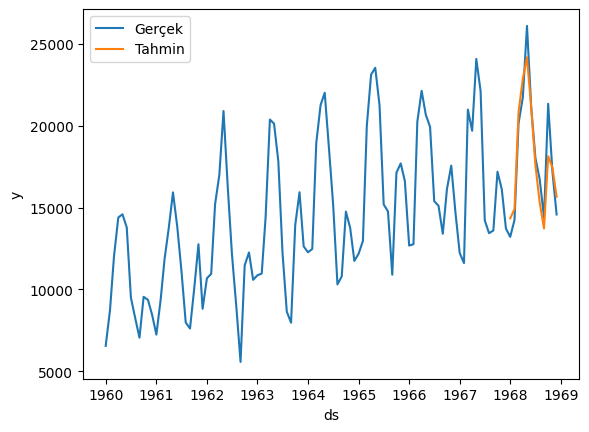

In [231]:
#Tahminleri çizdirme

plt.figure(figsize=(20, 20))

fig, ax = plt.subplots()
I1 = sns.lineplot(data=data, x="ds", y="y", ax=ax,label="Gerçek")
I2 = sns.lineplot(data=forecasting, x="ds", y="yhat", ax=ax,label="Tahmin")

# Grafiğin sağ üstünde Turuncu olanı Tahmin, diğerini ise Gerçekler yazdırmak için legend etiketleri ekleyin
ax.legend(loc="upper left")

plt.show()

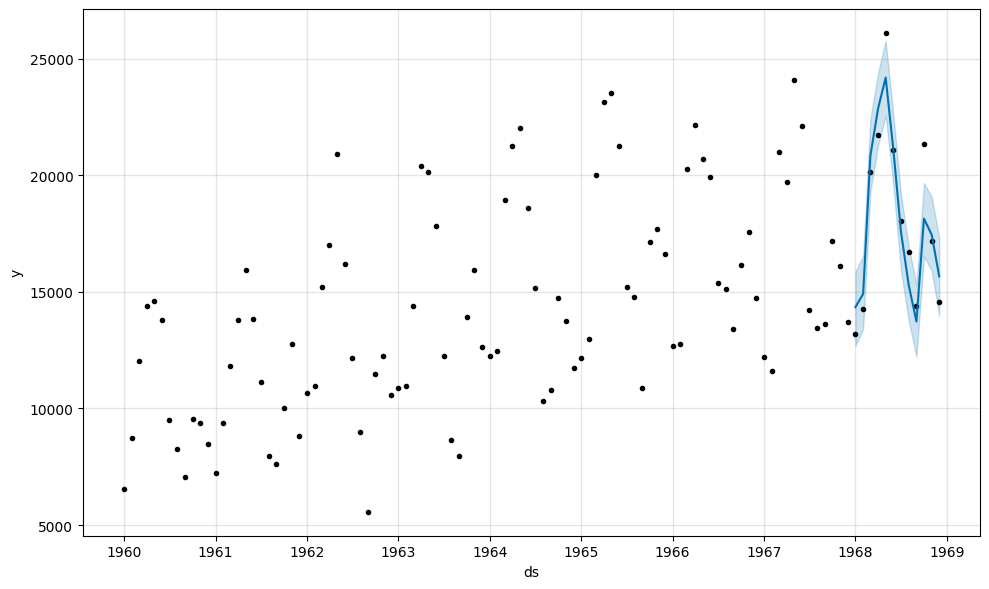

In [232]:
#Bu şekilde de bakabiliriz
model.plot(forecasting)
plt.show()

### Gelecekle ile tahmin yapmak

In [233]:
future=createDateTime(1969,1,13)

In [234]:
future=pd.DataFrame(data=future,columns=["ds"])
future.head(3)

,ds
0,1969-01
1,1969-02
2,1969-03


In [235]:
future['ds'] = pd.to_datetime(future['ds'])
print(future.dtypes)

ds    datetime64[ns]
dtype: object


In [236]:
future_forecasting=model.predict(future)

<Figure size 2000x2000 with 0 Axes>

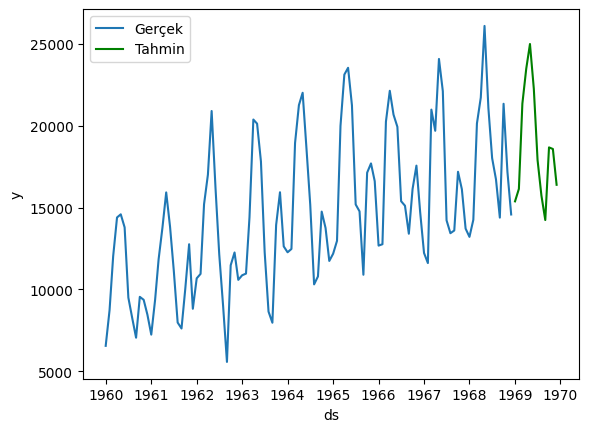

In [237]:
plt.figure(figsize=(20, 20))

fig, ax = plt.subplots()
I1 = sns.lineplot(data=data, x="ds", y="y", ax=ax, label="Gerçek")
I2 = sns.lineplot(data=future_forecasting, x="ds", y="yhat",
                  ax=ax, label="Tahmin", color="g")

# Grafiğin sağ üstünde Turuncu olanı Tahmin, diğerini ise Gerçekler yazdırmak için legend etiketleri ekleyin
ax.legend(loc="upper left")

plt.show()

## Test verisi oluştururak tahmin etme

In [238]:
# Artık verimizin son 12 ayını kaldırıp, bunu kendimiz bir model yaratıp aralarındaki farkı karşılaştıralım.


train = data.drop(data.index[-12:])  # son 12 indexi silme
train.tail(12)

# 1968 yılını kaldırdık.

,ds,y
84,1967-01-01,12225
85,1967-02-01,11608
86,1967-03-01,20985
87,1967-04-01,19692
88,1967-05-01,24081
89,1967-06-01,22114
90,1967-07-01,14220
91,1967-08-01,13434
92,1967-09-01,13598
93,1967-10-01,17187


In [239]:
#Şimdi yeni bir dataFrame oluşturalım. Ve modelin tahmin etmesini sağlayalım.

df1968=createDateTime(1968,1,13)


#List ---> dataFrame
df1968=pd.DataFrame(data=df1968,columns=["ds"])


#Kolon tipini değiştirme
df1968["ds"]=pd.to_datetime(df1968["ds"])


In [240]:
#Modeli eğitme
model = Prophet()


model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [241]:
#Tahmin oluşturma
forecast=model.predict(df1968)

In [242]:
y_true = data['y'][-12:].values #Gerçek değerler
y_pred = forecast['yhat'].values #Tahmin edilen değer

In [243]:
mae = mean_absolute_error(y_true, y_pred) #Her bir tahmin ile gerçek arasındaki ortalama fark
print('MAE: %.3f' % mae)

MAE: 1336.813


### Görselleştirme

<Figure size 2000x2000 with 0 Axes>

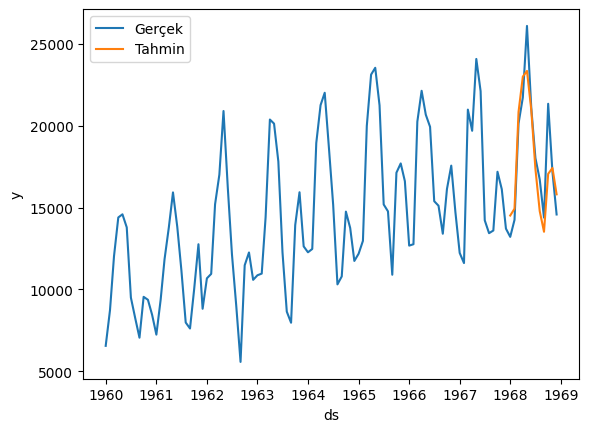

In [244]:
plt.figure(figsize=(20, 20))

fig, ax = plt.subplots()
I1 = sns.lineplot(data=data, x="ds", y="y", ax=ax,label="Gerçek")
I2 = sns.lineplot(data=forecast, x="ds", y="yhat", ax=ax,label="Tahmin")

# Grafiğin sağ üstünde Turuncu olanı Tahmin, diğerini ise Gerçekler yazdırmak için legend etiketleri ekleyin
ax.legend(loc="upper left")

plt.show()

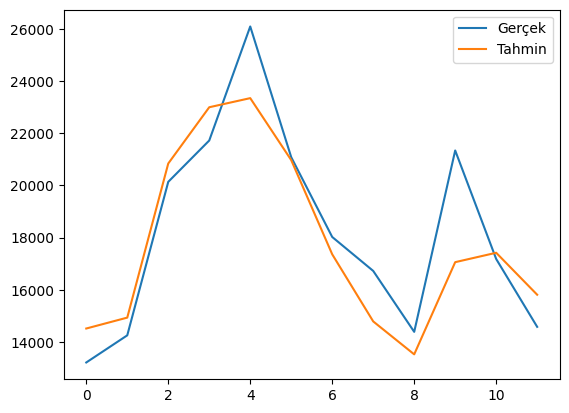

In [245]:
#1968'e odaklanalım..

plt.plot(y_true,label="Gerçek")
plt.plot(y_pred,label="Tahmin")
plt.legend()
plt.show()

In [ ]:
#Done!